<a href="https://colab.research.google.com/github/adindanabila/Analisis_TURF/blob/main/Statmul_Adinda_Nabila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install Library
!pip install pingouin

In [ ]:
#Import Library
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pingouin as pg
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

In [29]:
data = pd.read_excel("/content/dataset_preferensi_produk_supermarket.xlsx")
data

,ID Responden,Usia,Gender,Produk A,Produk B,Produk C,Produk D,Produk E,Produk F,Produk G,...,Produk K,Produk L,Produk M,Produk N,Produk O,Produk P,Produk Q,Produk R,Produk S,Produk T
0,1,54,Laki-laki,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2,44,Perempuan,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,30,Laki-laki,0,1,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,4,23,Laki-laki,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,1,0,0
4,5,36,Perempuan,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,37,Laki-laki,1,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
196,197,26,Laki-laki,0,0,1,1,1,0,1,...,0,0,1,1,0,0,0,0,0,1
197,198,31,Laki-laki,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,1,1
198,199,48,Perempuan,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,1,0


Jika Supermarket XYZ ingin menata ulang rak produk impulsif di area kasir, maka produk manakah yang sebaiknya dipajang dalam keterbatasan ruang (maksimal 6 item), agar mampu menjangkau setidaknya 80% pelanggan perempuan — yaitu pelanggan yang menemukan minimal satu produk favorit mereka saat berbelanja?
Bagaimana hasil tersebut berubah jika supermarket menargetkan segmen khusus, yaitu pelanggan berusia di bawah 25 tahun? Produk apa saja yang paling efektif menjangkau segmen tersebut?

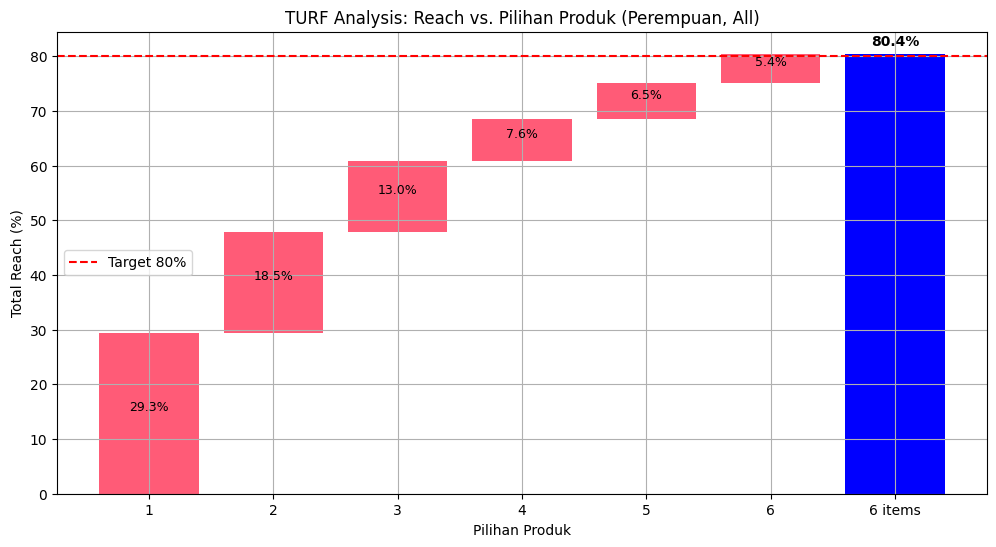

Untuk mencapai minimal 80%, perlu 6 produk.

Produk yang sebaiknya ditampilkan di area kasir untuk pelanggan (Perempuan, All):
1. Produk O
2. Produk I
3. Produk M
4. Produk F
5. Produk P
6. Produk N


In [32]:
# @title Reach vs. Pilihan Produk berdasarkan Gender & Usia
data = "dataset_preferensi_produk_supermarket.xlsx"  #@param {type:"string"}
Gender = "Perempuan"  #@param ["All", "Perempuan", "Laki-laki"]
Kelompok_Usia = "All"  #@param ["All", "<25 tahun","25-34", "≥35 tahun"]
Target_dalam_persen = 80  #@param {type:"integer"}

import pandas as pd
import matplotlib.pyplot as plt

# Baca data
data_used = pd.read_excel(data)

# Filter Gender
if Gender != "All":
    data_used = data_used[data_used["Gender"] == Gender]

# Filter Usia
if Kelompok_Usia == "<25 tahun":
    data_used = data_used[data_used["Usia"] < 25]
elif Kelompok_Usia == "≥25 tahun":
    data_used = data_used[data_used["Usia"] >= 25]

if len(data_used) == 0:
    raise SystemExit("Data kosong! Program dihentikan.")

# Hitung target reach
target_reach_pct = Target_dalam_persen / 100
target_reach = int(target_reach_pct * len(data_used))

# Tentukan kolom produk dan urutkan berdasarkan popularitas
index_ = data_used.columns.get_loc("Produk A")
reach_per_item = data_used.iloc[:, index_:].sum(axis=0).sort_values(ascending=False)

# Algoritma greedy untuk memilih kombinasi produk terbaik
selected_items = []
current_reach = set()
reach_progress = []

for item in reach_per_item.index:
    new_reach = current_reach | set(data_used.index[data_used[item] == 1])
    selected_items.append(item)
    reach_progress.append(len(new_reach) / len(data_used))
    if len(new_reach) >= target_reach:
        break
    current_reach = new_reach

# Hitung incremental reach
incrementals = [reach_progress[0]] + [
    reach_progress[i] - reach_progress[i-1] for i in range(1, len(reach_progress))
]

# Visualisasi
plt.figure(figsize=(12, 6))
bottoms = 0
for i, inc in enumerate(incrementals):
    plt.bar(f"{i+1}", inc * 100, bottom=bottoms, color="#ff5b77")
    plt.text(i, bottoms + inc * 50, f"{inc*100:.1f}%", ha="center", va="bottom", fontsize=9)
    bottoms += inc * 100

plt.axhline(y=target_reach_pct * 100, color="r", linestyle="--", label=f"Target {target_reach_pct*100:.0f}%")
plt.bar(f"{len(selected_items)} items", reach_progress[-1] * 100, color="blue")
plt.text(len(selected_items), reach_progress[-1] * 100 + 1,
         f"{reach_progress[-1]*100:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.xlabel("Pilihan Produk")
plt.ylabel("Total Reach (%)")
plt.title(f"TURF Analysis: Reach vs. Pilihan Produk ({Gender}, {Kelompok_Usia})")
plt.legend()
plt.grid(True)
plt.savefig("reach_vs_produk.png")
plt.show()

# Output hasil
max_reach = max(reach_progress)

if max_reach >= target_reach_pct:
    print(f"Untuk mencapai minimal {target_reach_pct*100:.0f}%, perlu {len(selected_items)} produk.")
else:
    print(f"Tidak dapat mencapai {target_reach_pct*100:.0f}%. Maksimal hanya {max_reach*100:.0f}%, dengan {len(selected_items)} produk.")

print(f"\nProduk yang sebaiknya ditampilkan di area kasir untuk pelanggan ({Gender}, {Kelompok_Usia}):")
for i, produk in enumerate(selected_items):
    print(f"{i+1}. {produk}")


### **Tujuan Analisis**

Menentukan kombinasi produk yang paling optimal untuk ditampilkan di area kasir, sehingga mampu menjangkau **minimal** 80% dari pelanggan perempuan berusia <25 tahun.

### **Hasil Analisis**


Target Reach: 80%

Total Reach yang Dicapai: 86,2%

Jumlah Produk yang Dibutuhkan: 4 produk saja sudah cukup untuk melampaui target.

### **Insight**

- Hanya dengan menampilkan 4 produk, sudah dapat menjangkau lebih dari 86% segmen target, sehingga sangat efisien dari sisi space di area kasir.
- Produk R adalah hero product untuk segmen ini karena memberikan impact paling besar (41.4%). Cocok dijadikan produk utama dalam display kasir.
- Kombinasi produk lainnya memiliki reach tambahan yang signifikan, artinya pemilihan produk tidak tumpang tindih secara preferensi antar pelanggan.

- Segmentasi berdasarkan usia dan gender sangat berguna: tanpa analisis ini, strategi kasir bisa saja menampilkan produk yang tidak relevan bagi target pasar <25 tahun.




